$$
\newcommand{\F}{\mathbb{F}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\L}{\mathbf{L}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\v}{\mathbf{v}}
\newcommand{\a}{\mathbf{a}}
\newcommand{\b}{\mathbf{b}}
\newcommand{\c}{\mathbf{c}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\u}{\mathbf{u}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\1}{\mathbf{1}}
$$

## Terminologies

### Feature Maps

[Feature Maps](https://stats.stackexchange.com/questions/291820/what-is-the-definition-of-a-feature-map-aka-activation-map-in-a-convolutio) has an [intuitive interpretation](https://www.quora.com/What-is-meant-by-feature-maps-in-convolutional-neural-networks). Imagine a 32 by 32 image, consider that a convolutional layer applied on the input and we assume only 1 single filter, then only 1 single feature map is obtained, this feature map's corresponding filter can be [sobel's filter](https://en.wikipedia.org/wiki/Sobel_operator) where it detects edges. Then assume this single filter is 5 by 5, then after applying to the 32 by 32 image, the resulting output is 28 by 28, although "downsampled", this feature map should still capture valueble spatial information of the 32 by 32 image, and in this case, all edges of the input image (say a cat) will be shown in the feature map.

### Global Average Pooling (GAP)

One might wonder the step where the paper applied **GAP** over each feature map $\A_k$. One can refer to [here](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to understand the intuition here.

## The Intuition

> This part is referenced from **Interpretable Machine Learning by Christoph Molnar**. He started off with an intuitive description of Grad-CAM.

- **High level idea:** Grad-CAM is to understand at which parts of an image a convolutional layer "looks" for a certain classification.
- As a reminder, the first convolutional layer of a CNN takes as input the images and outputs feature maps that encode learned features (see the chapter on [Learned Features](#cnn-features)).
    - The higher-level convolutional layers do the same, but take as input the feature maps of the previous convolutional layers.
- To understand how the CNN makes decisions, Grad-CAM analyzes which regions are activated in the feature maps of the last convolutional layers.
- There are $k$ feature maps in the last convolutional layer, and I will call them $\A^1, \A^2, \ldots, \A^k$.
- How can we "see" from the feature maps how the convolutional neural network has made a certain classification?
    - In the first approach, we could simply visualize the raw values of each feature map, average over the feature maps and overlay this over our image. This is the method of visualization feature map activations.
    - This would not be helpful since the feature maps encode information for **all classes**, but we are interested in a particular class.
    - Grad-CAM has to decide how important each of the k feature map was to our class c that we are interested in.
- We have to weight each pixel of each feature map with the gradient before we average over the feature maps.
- This gives us a heatmap which highlights regions that positively or negatively affect the class of interest.
- This heatmap is send through the `ReLU` function, which is a fancy way of saying that we set all negative values to zero.
    - Grad-CAM removes all negative values by using a ReLU function, with the argument that we are only interested in the parts that contribute to the selected class c and not to other classes.
- The word pixel might be misleading here as the feature map is smaller than the image (because of the pooling units) but is mapped back to the original image.
- We then scale the Grad-CAM map to the interval [0,1] for visualization purposes and overlay it over the original image.

## The Algorithm

### Notation

- Input image: $\X$

- **Feature Maps** of the last convolutional layer in a CNN is denoted as:

    $$\A_1, \A_2, \ldots, \A_k$$
    
    The $k$ is an arbitrary number for the number of feature maps.

- The **Feature Logits** of a particular **class $c$** is denoted as:
    
    $$\y^{c}$$
    
    In other words, in **ImageNet**, the elephant class is indexed $386$, and is denoted $\y^{386}$. This is also the raw feature logits output of the last convolutional layer.
    
- The **gradient of the fully-connected logits for class $c$, $\y^{c}$ (before the softmax), with respect to feature map activations $\A_k$ of a convolutional layer**:
    
    $$\dfrac{d\y^{c}}{d\A^{k}}$$
    
- It follows that the **gradient of the fully-connected for each class $c$, $\y^{c}$, with respect to each pixel on the feature map activations $\A_k$ is denoted as**:
    
    $$\dfrac{d\y^{c}}{d\A^{k}_{ij}}$$
    
- Denote the `ReLU` function as:
    
    $$\textbf{ReLU}$$

- The final heatmap, also called the localization map of Grad-CAM is denoted as:

    $$\L^{c}_{Grad-CAM} \in \R^{w \times h}$$
    
    where $w$ and $h$ is the width and height of the final output localization map.
    
    and is equals to
    
    $$\L^{c}_{Grad-CAM} \in \R^{w \times h} = \textbf{ReLU} \left(\overbrace{\frac{1}{Z}\sum_{i}\sum_{j}}^{\text{global average pooling}} \underbrace{\frac{\delta y^c}{\delta A_{ij}^k}}_{\text{gradients via backprop}}\right)$$

### The Algorithm

<!-- Pseudo code-->
Let us look at the recipe for Grad-CAM.
Our goal is to find the localization map, which is defined as:

$$L^c_{Grad-CAM} \in \mathbb{R}^{u\times v} = \underbrace{ReLU}_{\text{Pick positive values}}\left(\sum_{k} \alpha_k^c A^k\right)$$


Here, u is the width, v the height of the explanation and c the class of interest.

1. Forward-propagate the input image through the convolutional neural network.
1. Obtain the raw score for the class of interest, meaning the activation of the neuron before the softmax layer.
1. Set all other class activations to zero.
1. Back-propagate the gradient of the class of interest to the last convolutional layer before the fully connected layers: $\frac{\delta{}y^c}{\delta{}A^k}$.
1. Weight each feature map "pixel" by the gradient for the class. Indices i and j refer to the width and height dimensions:
   $$\alpha_k^c = \overbrace{\frac{1}{Z}\sum_{i}\sum_{j}}^{\text{global average pooling}} \underbrace{\frac{\delta y^c}{\delta A_{ij}^k}}_{\text{gradients via backprop}}$$
This means that the gradients are globally pooled.
1. Calculate an average of the feature maps, weighted per pixel by the gradient.
1. Apply ReLU to the averaged feature map.
1. For visualization: Scale values to the interval between 0 and 1. Upscale the image and overlay it over the original image.
1. Additional step for Guided Grad-CAM: Multiply heatmap with guided backpropagation.


#### Step 1: Forward-propagate the input image through the convolutional neural network

This step just takes in **one single image** $\X$ and perform a forward pass through the CNN.

- `last_conv_layer_output`
    - Shape: $2 \times 2 \times 3$ with 3 filters of 2 by 2 shape.
    - Note this is just $\A^1, \A^2, \A^3$ where each $\A^k \in \R^{2 \times 2}$.

- `y_logits`
    - Shape: $1 \times 1000$ since there are 1000 classes in ImageNet.
    - Note that this is our $\y$. If we are interested in the elephant class at index 386, then we denote it as $\y^{c} = \y^{386}$.
    - Thus, $\y \in \R^{1 \times 1000}$ but $\y^{c} \in \R^{1 \times 1}$.
    - Note carefully this is the logits output of **all the layers** of the CNN, and is just right before the **softmax** where we transform the logits to probabilities.
    - We can imagine that among these 1000 logits, the highest number means the model thinks that this index is the most probable class.
    - Theoretically speaking, there is no difference in differentiation of the logits wrt to the feature maps versus the softmax probs wrt to the feature maps. This is because **softmax is monotonic**, and the pre-softmax logits output will tell us already which class is most probable, and so will the softmax. So there should not be any confusion here on why we did not differentiate softmax probs wrt to the feature maps instead since the ranking is preserved in the sense that values in logits the highest is the most probable when transformed by softmax.

- `target_category`
    - This is an optional argument in the function. 
    - If `None`, we will automatically assign it to the highest logit's index.
    - In this example, the highest logit in $\y$ is at index 386 with a value of $23.632$, corresponding to the target class of elephant.
    - If specified, then the $\y^{c}$ will change.

- `target_category_logits`
    - Once our `target_category` is defined, we will just slice `y_logits[:, target_category]` to get the logit value of that particular class.
    - This variable is just $\y^{c}$ if you look carefully.

- `grads = tape.gradient(target_category_logits, last_conv_layer_output)`
    - This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer.
    - This has shape $2 \times 2 \times 3$ in our simple example. In the python example, the shape at this moment has an additional axis like $1 \times 2 \times 2 \times 3$ which we will eventually squeeze it anyways.
    - Notice it has the same shape as `last_conv_layer_output` aka the feature maps.
    - In other words, this variable has 3 feature maps stacked together and can be visualized as:     
    
        $$\begin{bmatrix} \dfrac{d\y^{c}}{d\A^{1}} & \dfrac{d\y^{c}}{d\A^{2}} & \dfrac{d\y^{c}}{d\A^{3}} \end{bmatrix}$$

- `pooled_grads`
    - Shape: $3 \times 1$
    - This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel.
    - In other words, in `grads[0]` we have $\frac{d\y^c}{d\A^1}$ which is of shape $2 \times 2$. What we do not is **Global Average Pooling** on these gradients where we just take the average of all available pixels in this $2 \times 2$ gradient map for feature map 1. You can find more intuition of GAP above, but in general this is similar logic to how you perform GAP on the output of the feature logits from the last conv layer.
    
        $$\alpha_k^c = \overbrace{\frac{1}{Z}\sum_{i}\sum_{j}}^{\text{global average pooling}} \underbrace{\frac{\delta y^c}{\delta A_{ij}^k}}_{\text{gradients via backprop}}$$
        
        where $Z$ is the total number of pixels in this gradient map.

- `heatmap`
    - Shape: $2 \times 2$ which is also the filter size and also the feature map size.
    - This is the weighted sum of all feature maps $\A^1, \A^2, \A^3$ and is
        
        $$\textbf{Localized_Map} = \left(\sum_{k} \alpha_k^c A^k\right)$$

### The big picture

The big picture is when you "reduce" the 3 feature maps into 1 single new "feature map" (localization map) by way of a linear sum where each feature map $\A^k$ is multiplied by the global average pooled gradients $\alpha_k^c$. In the example on my drawings, it can be seen that feature maps $\A^1$ and $\A^2$ are more important for the model to distinguish the elephant class than that of $\A^3$. 

By design, I made $\A^3$ in itself already look different in terms of values from $\A^1$ and $\A^2$ on the get go. But at this point in time, even though we know the values in feature map $\A^3$ are vastly different, we cannot say for sure whether $\A^3$ in itself contributed to the prediction of our class elephant or not. It could also be the case that $\A^1$ and $\A^2$ are bonkers. Thus, the concept of taking the **gradient** of the class $\y^c$ with respect to each of these feature maps $\A^k$ becomes increasingly important as now we have a mathematical way to assign some importance to each of these feature maps.

Now to even further bring out the intuition, imagine the 3 feature maps for the input image elephant as follows:

- Feature map $\A^1$ corresponds to Sobel Filter where it detect edges in particular their **trunk** of the **elephants**.
- Feature map $\A^2$ corresponds to Another Filter where it detects the **ear** of the **elephants**.
- Feature map $\A^3$ corresponds to a Background Filter where it detect the background and in particular the grass patch under the **elephants**.

---

Now this is apparent why $\A^3$ is vastly different in terms of values since it is actually representing the background and grass. We know that grass is a non-factor in determining an elephant since the african grass field can hold many other animals as well. We really do not want the model to assign important to the grass, if any at all. 

We can then compute the gradient of $\y^c$ wrt each feature map and we can intuitively understand it as (see my diagrams):

- Gradient map $\frac{d\y^{386}}{d\A^1}$ has values $[2, 3, 4, 2]$ 
    - These values are the gradients of feature map $\A^1$ at a pixel level. We may find it difficult to comprehend these gradients and we want a quick summary of how feature map $\A^1$ changes our model's decision for $\y^{386}$. Thus we use GAP.
    - and when we perform GAP on them, we have $\alpha_{1}^{386} = 2.75$. 
    - This value roughly translates to a pertubation of $2.75$ in feature map $\A^1$ will result in a unit change in our class $\y^{386}$.
- Gradient map $\frac{d\y^{386}}{d\A^2}$ has values $[3, 5, 6, 3]$ and when we perform GAP on them, we have $4.25$. 
    - The same logic applies.
- Gradient map $\frac{d\y^{386}}{d\A^3}$ has values $[0.1, -0.1, 0.2, 0.2]$ and when we perform GAP on them, we have $0.1$.
    - The same logic applies and we see that the gradient is small here and hence we can deduce that this feature map is not very important.

---




Ultimately however, we want to know how the change in **all feature maps $\A^k$** affects our final decision. This is where we perform a linear sum of $\left(\sum_{k} \alpha_k^c A^k\right)$ of all feature maps with the weight coefficient being their global average pooled gradient map. Just like our good old linear regression model, the intuition is the same as in $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ...$. The coefficients (the gradient values of $2.75, 4.25, 0.1$ decides which feature map are important and gets "activated and highlighted").

- We get the weighted sum heatmap to be the shape $(2, 2)$ of values $[8.925, -2.025, 16.125, 2.6]$. Now this is a very small map and is likely not going to happen in real life. More often the map at this stage is of size $(10, 10)$ and beyond. Imagine once more how $\A^3$ played almost no role.
---

Lastly, an elementwise `ReLU` operation is applied to the heatmap to get $[8,925, 0, 16.125, 2.6]$ and from the paper: We apply a `ReLU` to the linear combination of maps because we are only interested in the features that have a positive influence on the class of interest, i.e. pixels whose intensity should be increased in order to increase `y^{c}`. Intuitively, the idea is that negative values contribute to other classes and we should not really care about it.

We can scale back the heatmap to overlay on the original image.

From [here](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82), author said:

> Another potential question that can arise is why wouldn’t we just compute the gradient of the class logit with respect to the input image. Remember that a convolutional neural network works as a feature extractor and deeper layers of the network operate in increasingly abstract spaces. We want to see which of the features actually influenced the model’s choice of the class rather than just individual image pixels. That is why it is crucial to take the activation maps of deeper convolutional layers.

In [57]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform


    def __len__(self):
        return 1000

    def __getitem__(self, x):
        # read 1 image only so no need subset idx
        image_path = self.image_path
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = 0
     
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [66]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

elephant_path = "../images/animals/elephant.png"
# define a 1 image dataset
elephant_dataset = CustomDataset(image_path = elephant_path, transform = transform)

# define the dataloader to load that single image
elephant_dataloader = torch.utils.data.DataLoader(dataset=elephant_dataset, shuffle=False, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


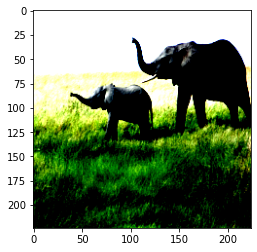

In [67]:
# get some random training images
dataiter = iter(elephant_dataloader)
images, labels = dataiter.next()

# show images
plt.imshow(np.transpose(torchvision.utils.make_grid(images), (1, 2, 0)))


In [69]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [71]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(elephant_dataloader))

# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)

In [73]:
pred

tensor([386])

In [76]:
# get the gradient of the output with respect to the parameters of the model
# pred[:, 386].backward() # cannot use this as we only have 1 class, image 1000 classes then use this

pred.backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

None


TypeError: mean() received an invalid combination of arguments - got (NoneType, dim=list), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [ ]:
import cv2 elephant_path
img = cv2.imread('./data/Elephant/data/05fig34.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

In [68]:
num_classes = 1

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*54*54, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = LeNet()
net = net.to(device)